# Lab 4 - Active Causal Inference Estimation



The details of the codes are available: https://github.com/jiwoongim/Causal-Inference-Tutorial/

For any who wants to run along you can add this to your code cell in the beginning

!git clone https://github.com/jiwoongim/Causal-Inference-Tutorial.git

And then before from util….

import sys
sys.path.append('/content/Causal-Inference-Tutorial/ci/src/ci')

In [1]:
import sys

sys.path.append('/teamspace/studios/this_studio/2024-causal-inference-machine-learning/Causal-Inference-Tutorial/ci/src/ci')
sys.path.append('/teamspace/studios/this_studio/2024-causal-inference-machine-learning/Causal-Inference-Tutorial/ci/src')

In [2]:
import argparse
from dataclasses import dataclass

from rct import BanditArm
from nrct import NRCTBanditArm
from thompson import ThompsonBandit
from util import MEAN, SE, Bookkeeping

### SCRIPT

In [7]:

@dataclass
class ArgParse:
    algo_type: str = "rct"
    num_run: int = 10000
    num_action: int = 2
    param_a : float = 0.5

def get_model(args):
    if args.algo_type == "thompson":
        return ThompsonBandit(args.num_action, param_a=args.param_a)
    elif args.algo_type == "nrct":
        return NRCTBanditArm(args.num_action, param_a=args.param_a)
    return BanditArm(args.num_action, param_a=args.param_a)

def get_action(args, model, x):
    if args.algo_type == "rct":
        return model.sample_action()
    return model.sample_action_given_covariate(x)

def main(args):
    experiment = Bookkeeping(args.num_action)

    model = get_model(args)
    for i in range(args.num_run):
        x_i = model.sample_covariate()
        a_i, p_i = get_action(args, model, x_i)
        y_i = model.sample_outcome(x_i, a_i)
        model.append_data(x_i, a_i, y_i, p_i)
        prob_actions = model.get_empirical_prob_actions()

        # Warmup - skip first 100 iteration.
        if i < 100:
            continue
        #print(f"Sampled Data: {x_i, a_i, y_i, p_i}, {prob_actions}")


        ## po - potential outcomes
        ## co - conditional outcomes
        po0_stats, co0_stats = model.compute_potential_outcome(action=0)
        po1_stats, co1_stats = model.compute_potential_outcome(action=1)
        ate_stat = model.compute_ate(treatment_ind=0)

        if i % 500 == 0:
            print(
                f"...Iteration {i}"
                + f"| EPO0 {po0_stats[MEAN]:.3f} +/- {po0_stats[SE]:.3f}"\
                + f"| EPO1 {po1_stats[MEAN]:.3f} +/- {po1_stats[SE]:.3f}"\
                + f"| PO0 {co0_stats/prob_actions[0]:.3f} PO1 {co1_stats/prob_actions[1]:.3f}"\
                + f"| CO0 {co0_stats:.3f} CO1 {co1_stats:.3f}"\
                + f"| PA0 {prob_actions[0]:.3f} PA1 {prob_actions[1]:.3f}"\
                + f"| ATE {ate_stat[MEAN]:.3f} +/- {ate_stat[SE]:.3f}"
            )
        experiment.add_potential_outcomes(i, [po0_stats, po1_stats])
        experiment.add_conditional_outcomes(i, [co0_stats, co1_stats])
        experiment.add_ate(i, ate_stat)

    fname=f"{args.algo_type}_bandit_{args.num_action}actions_{args.num_run}runs"
    if args.algo_type == 'rct':
        fname += f"_{model.param_a}paramA"
    experiment.save_figure(fname)

### Execute RCT using Bandit Algorithm

Prob A = 0.35570021693860077
...Iteration 500| EPO0 0.424 +/- 0.026| EPO1 0.432 +/- 0.015| PO0 0.420 PO1 0.434| CO0 0.151 CO1 0.278| PA0 0.359 PA1 0.641| ATE -0.007 +/- 0.030
...Iteration 1000| EPO0 0.426 +/- 0.018| EPO1 0.432 +/- 0.011| PO0 0.417 PO1 0.437| CO0 0.152 CO1 0.278| PA0 0.364 PA1 0.636| ATE -0.005 +/- 0.021
...Iteration 1500| EPO0 0.430 +/- 0.015| EPO1 0.430 +/- 0.009| PO0 0.416 PO1 0.438| CO0 0.153 CO1 0.277| PA0 0.368 PA1 0.632| ATE 0.000 +/- 0.017
...Iteration 2000| EPO0 0.423 +/- 0.013| EPO1 0.434 +/- 0.007| PO0 0.416 PO1 0.438| CO0 0.150 CO1 0.279| PA0 0.362 PA1 0.638| ATE -0.011 +/- 0.015
...Iteration 2500| EPO0 0.414 +/- 0.011| EPO1 0.439 +/- 0.007| PO0 0.417 PO1 0.438| CO0 0.147 CO1 0.283| PA0 0.353 PA1 0.647| ATE -0.025 +/- 0.013
...Iteration 3000| EPO0 0.419 +/- 0.010| EPO1 0.435 +/- 0.006| PO0 0.416 PO1 0.437| CO0 0.149 CO1 0.281| PA0 0.359 PA1 0.641| ATE -0.016 +/- 0.012
...Iteration 3500| EPO0 0.415 +/- 0.010| EPO1 0.437 +/- 0.006| PO0 0.416 PO1 0.437| CO0 0.1

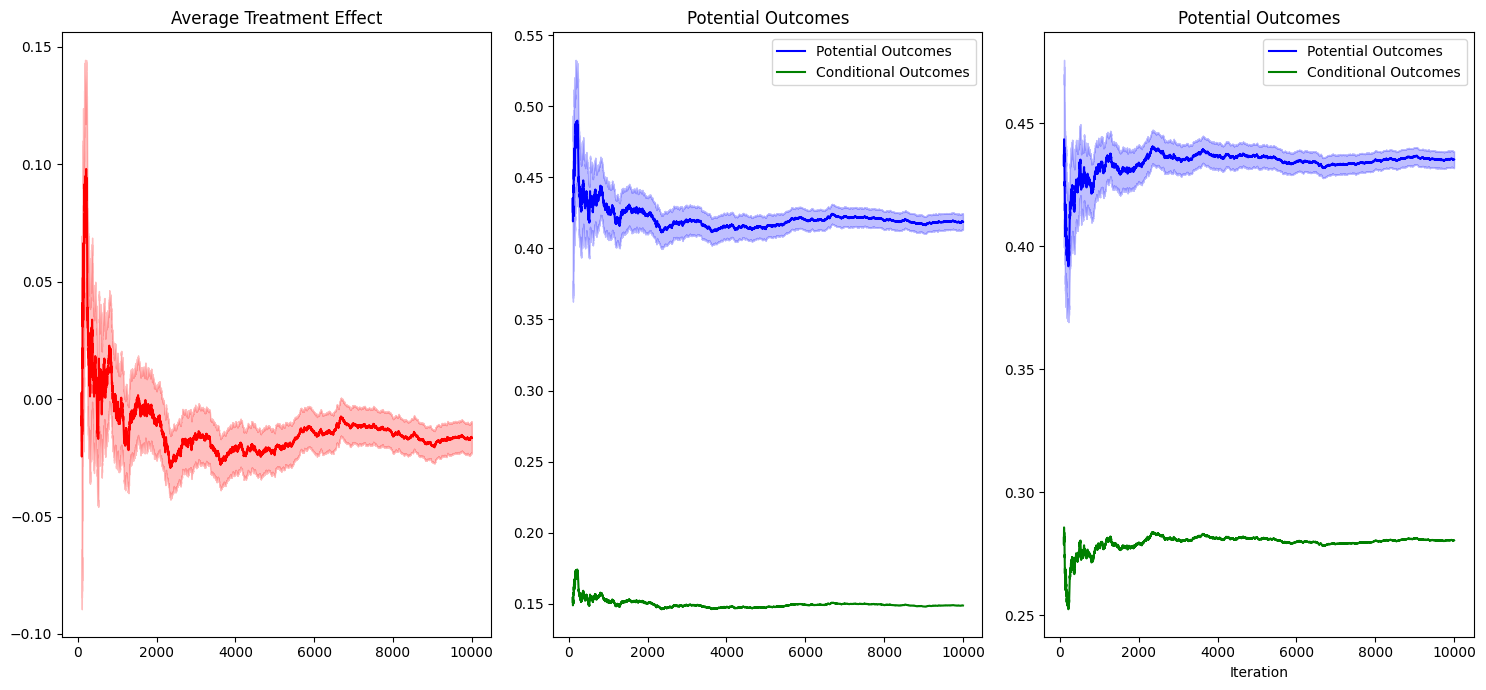

In [8]:
args = ArgParse()
main(args)

### Non-RCT but with fixed policy

Prob A = 0.33517462647751883


...Iteration 500| EPO0 0.401 +/- 0.026| EPO1 0.440 +/- 0.015| PO0 0.399 PO1 0.445| CO0 0.152 CO1 0.276| PA0 0.381 PA1 0.619| ATE -0.039 +/- 0.030
...Iteration 1000| EPO0 0.426 +/- 0.019| EPO1 0.427 +/- 0.011| PO0 0.399 PO1 0.446| CO0 0.160 CO1 0.267| PA0 0.401 PA1 0.599| ATE -0.001 +/- 0.022
...Iteration 1500| EPO0 0.434 +/- 0.016| EPO1 0.423 +/- 0.009| PO0 0.400 PO1 0.445| CO0 0.162 CO1 0.265| PA0 0.406 PA1 0.594| ATE 0.011 +/- 0.018
...Iteration 2000| EPO0 0.421 +/- 0.013| EPO1 0.431 +/- 0.008| PO0 0.400 PO1 0.445| CO0 0.158 CO1 0.269| PA0 0.395 PA1 0.605| ATE -0.010 +/- 0.015
...Iteration 2500| EPO0 0.412 +/- 0.012| EPO1 0.438 +/- 0.007| PO0 0.400 PO1 0.446| CO0 0.154 CO1 0.274| PA0 0.385 PA1 0.615| ATE -0.026 +/- 0.014
...Iteration 3000| EPO0 0.407 +/- 0.011| EPO1 0.439 +/- 0.006| PO0 0.400 PO1 0.446| CO0 0.153 CO1 0.275| PA0 0.383 PA1 0.617| ATE -0.032 +/- 0.012
...Iteration 3500| EPO0 0.404 +/- 0.010| EPO1 0.443 +/- 0.006| PO0 0.400 PO1 0.446| CO0 0.151 CO1 0.277| PA0 0.378 PA1 0

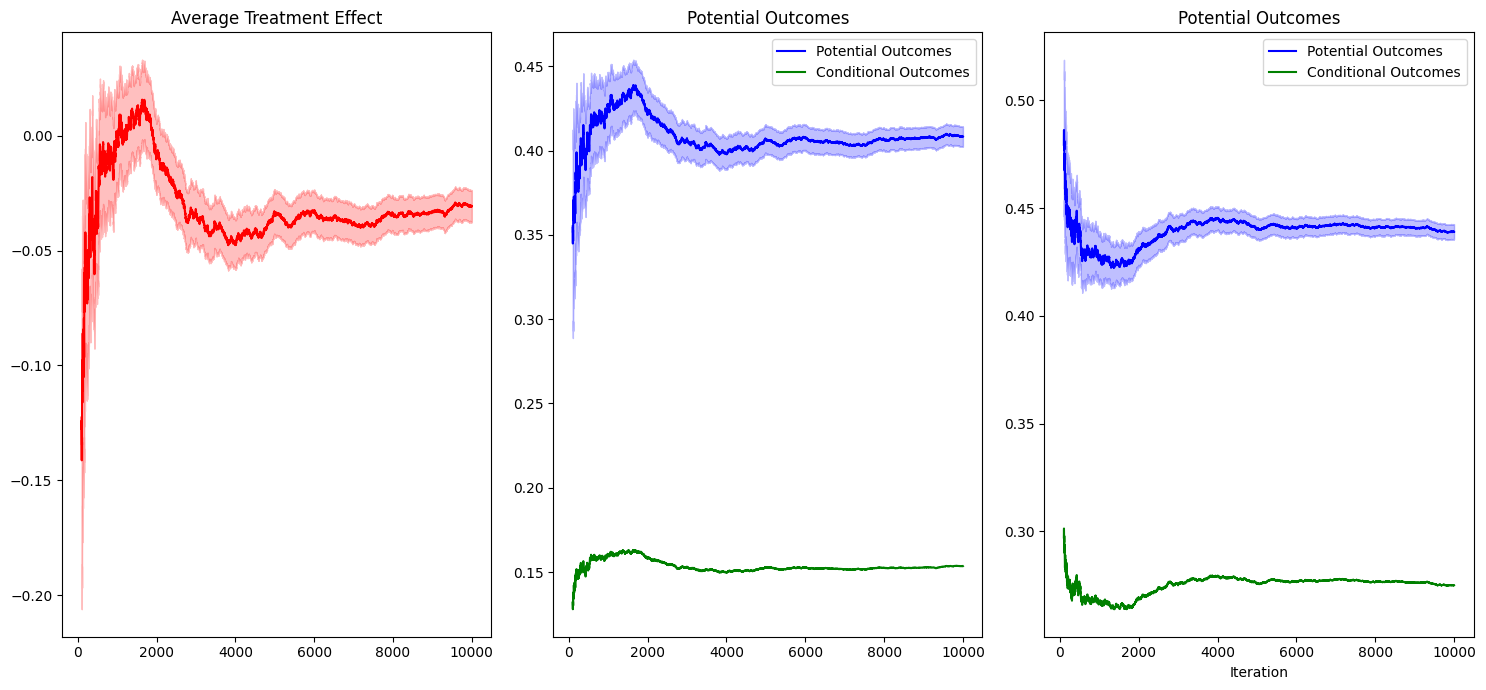

In [9]:
args = ArgParse()
args.algo_type = "nrct"
main(args)

### RUN Bandit using Thompson Sampling policy

Prob A = 0.35210909816090763
...Iteration 500| EPO0 0.440 +/- 0.019| EPO1 0.408 +/- 0.020| PO0 0.411 PO1 0.437| CO0 0.217 CO1 0.207| PA0 0.527 PA1 0.473| ATE 0.032 +/- 0.027
...Iteration 1000| EPO0 0.431 +/- 0.014| EPO1 0.421 +/- 0.014| PO0 0.414 PO1 0.437| CO0 0.212 CO1 0.213| PA0 0.512 PA1 0.488| ATE 0.010 +/- 0.019
...Iteration 1500| EPO0 0.415 +/- 0.011| EPO1 0.436 +/- 0.011| PO0 0.414 PO1 0.437| CO0 0.205 CO1 0.221| PA0 0.494 PA1 0.506| ATE -0.021 +/- 0.016
...Iteration 2000| EPO0 0.411 +/- 0.010| EPO1 0.440 +/- 0.010| PO0 0.414 PO1 0.437| CO0 0.203 CO1 0.223| PA0 0.490 PA1 0.510| ATE -0.029 +/- 0.014
...Iteration 2500| EPO0 0.413 +/- 0.009| EPO1 0.440 +/- 0.009| PO0 0.415 PO1 0.437| CO0 0.204 CO1 0.223| PA0 0.491 PA1 0.509| ATE -0.027 +/- 0.012
...Iteration 3000| EPO0 0.413 +/- 0.008| EPO1 0.441 +/- 0.008| PO0 0.416 PO1 0.438| CO0 0.204 CO1 0.223| PA0 0.491 PA1 0.509| ATE -0.028 +/- 0.011
...Iteration 3500| EPO0 0.411 +/- 0.007| EPO1 0.442 +/- 0.007| PO0 0.415 PO1 0.438| CO0 0.20

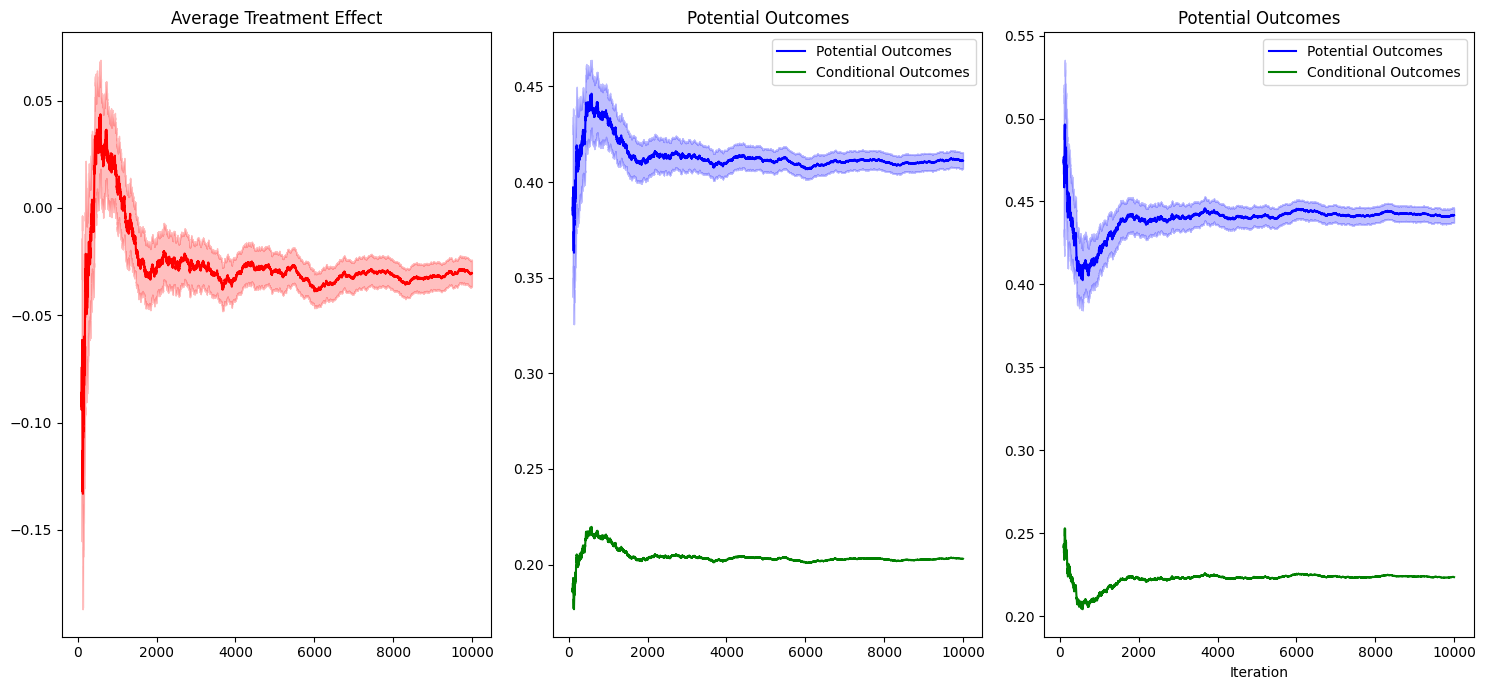

In [10]:
args = ArgParse()
args.algo_type = "thompson"
main(args)